# Project Final Report
 
Group: project-008-4  <br><br>

# Introduction

This project focuses on the prediction of playtime for Minecraft players. UBC Computer Science researcher Frank Wood and his team constructed a Minecraft server that collects data regarding players' behaviours. Their team aims to study how players interact with strangers in an online game environment. Using the data collected in this study, including variables such as age, gender, experience, and subscription status, this project aims to determine the kinds of players that are most likely to contribute to large amounts of data; in other words, long playtimes. 
This project utilizes the “players.csv” dataset to construct a prediction model. This dataset contains 196 observations. Each observation represents the data of one player registered on the server. 9 variables/columns are present in the dataset; each variable indicates a player’s identity. These variables are: 

**Categorical:**
- Minecraft experience level (beginner/amateur/regular/veteran/pro)
- player gender (male/female/non-binary/agender/two-spirited/prefer not to say) 
- individual ID 
- organization name
- hashed email 
- player's subscription status to the Plaicraft email list (true/false)

**Numerical:**
- played_hours (number of hours a player contributed ranging from 0 to 223.1) 
- player age (ranging from 9 to 99). 


In [51]:
#load the necessary packages
library(repr)
library(themis)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

In [52]:
#load the players data set
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players <- read_csv(url)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [53]:
#convert the players data set into a tidy format by removing unnecessary columns
players_tidy <- players |> 
    select(experience:age, -hashedEmail, -name) #|> #removed the hashedEmail and name columns
head(players_tidy)

experience,subscribe,played_hours,gender,age
<chr>,<lgl>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


We started the analysis by loading the dataset from the URL. Unecessary columns such as "hashedEmail" and "name" were removed to simplify the data and focus on relevant variables. 


Below we made some graphs showing the relationship between played hours and all the other variables. 

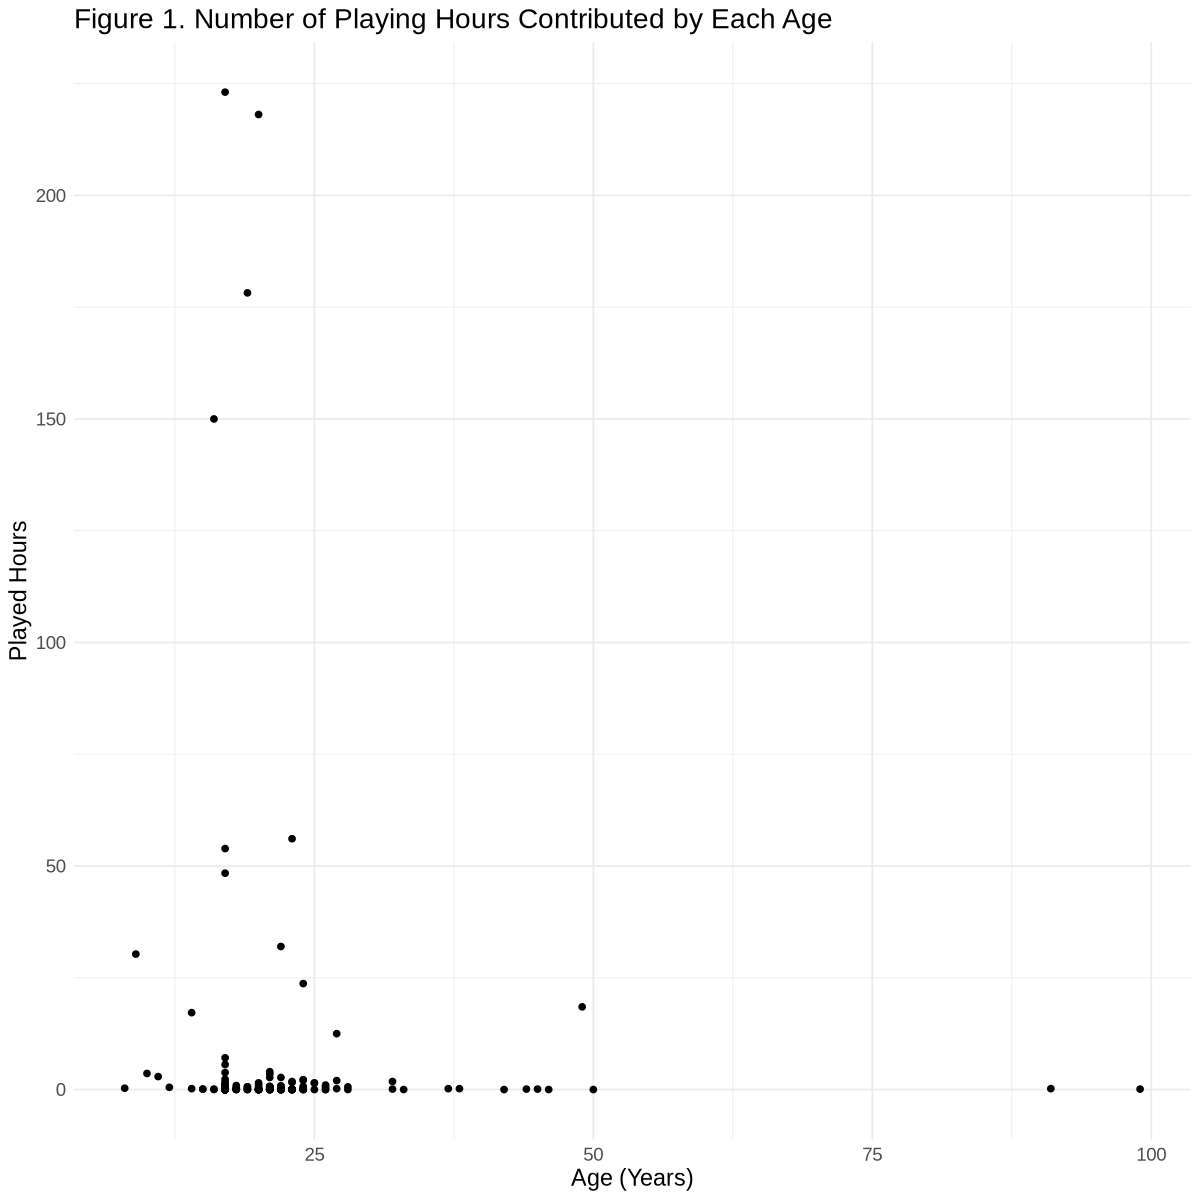

In [54]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(players_tidy, aes(x = age, y = played_hours)) +
  geom_point() + 
  labs(
    title = "Figure 1. Number of Playing Hours Contributed by Each Age",
    x = "Age (Years)",
    y = "Played Hours"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 14))

**Figure 1:** The scatter plot shows the playing hours contributed by individuals, with a concentration of high playing hours among ages 0 to 50. Contributions decrease significantly as age increases, with few data points beyond age 50.

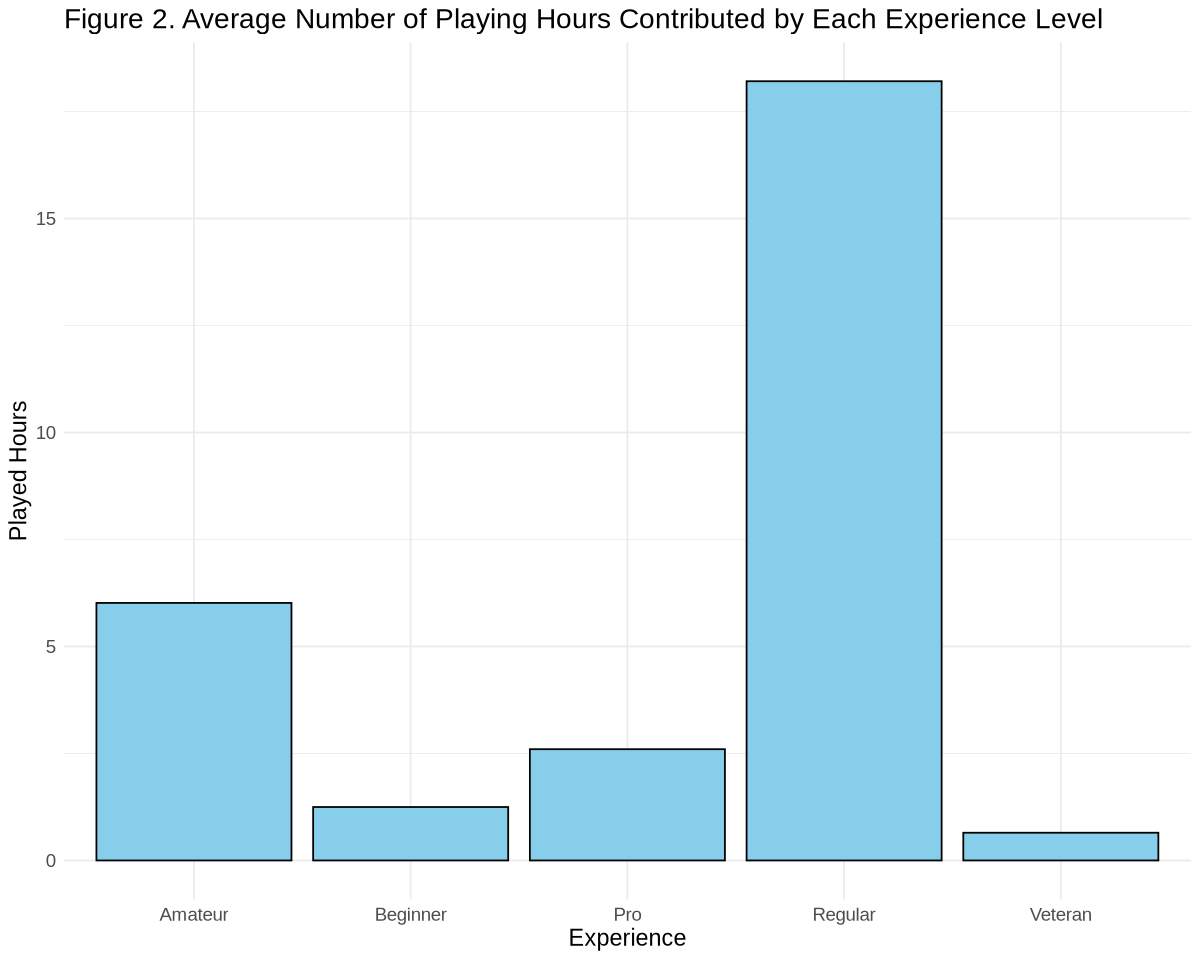

In [55]:
options(repr.plot.width = 10, repr.plot.height = 8)
experience_summary <- players_tidy |> 
  group_by(experience) |> 
  summarize(avg_hours = mean(played_hours, na.rm = TRUE))

# Create the bar graph
ggplot(experience_summary, aes(x = experience, y = avg_hours)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") + 
  labs(
    title = "Figure 2. Average Number of Playing Hours Contributed by Each Experience Level",
    x = "Experience",
    y = "Played Hours"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 14))

**Figure 2:** The bar chart illustrates the average playing hours contributed by different experience levels. Regular players contributed the most hours, followed by Amateurs, while other levels like Beginner, Pro, and Veteran contributed fewer hours.

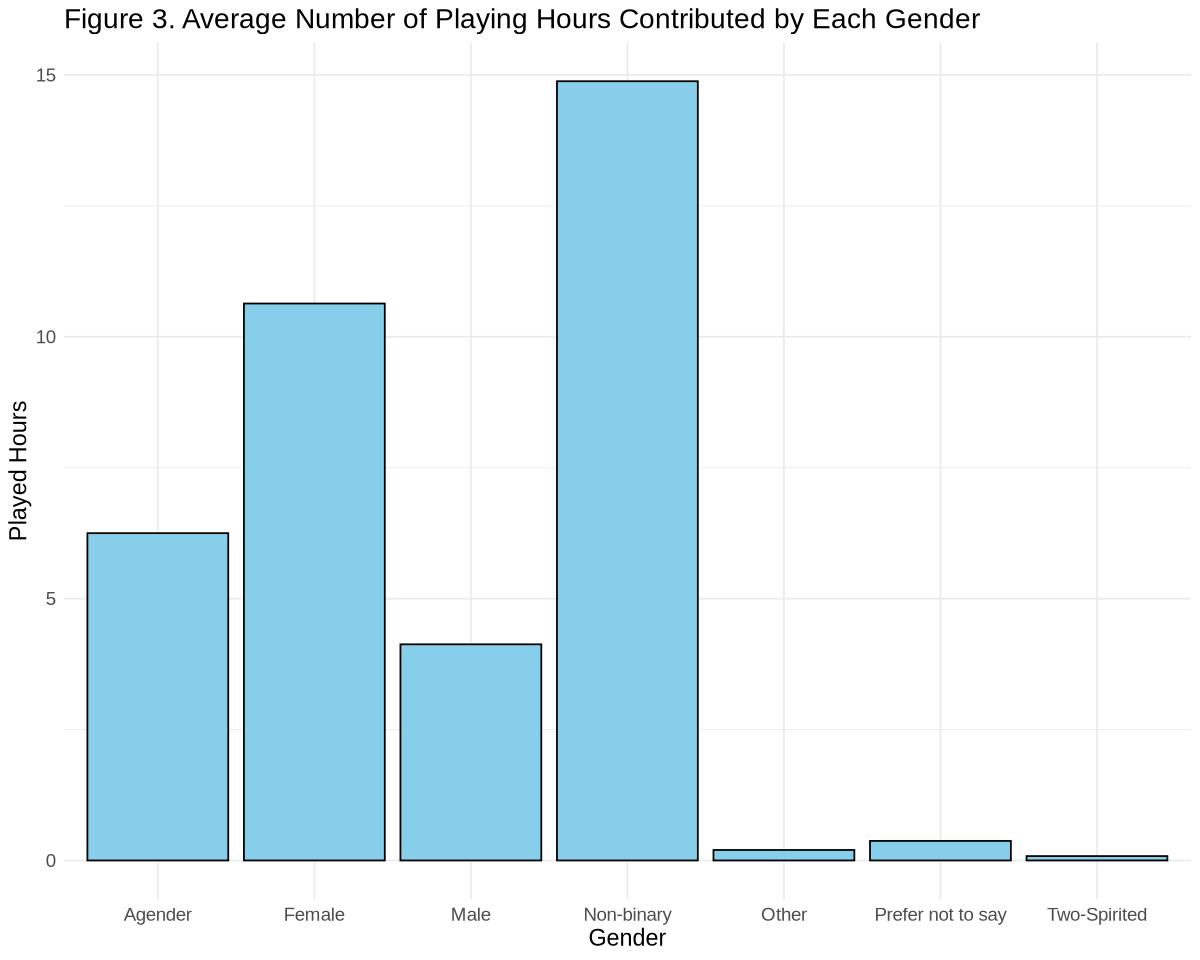

In [56]:
options(repr.plot.width = 10, repr.plot.height = 8)
gender_summary <- players_tidy |> 
  group_by(gender) |> 
  summarize(avg_hours = mean(played_hours, na.rm = TRUE))

# Create the bar graph
ggplot(gender_summary, aes(x = gender, y = avg_hours)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") + 
  labs(
    title = "Figure 3. Average Number of Playing Hours Contributed by Each Gender",
    x = "Gender",
    y = "Played Hours"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 14))

**Figure 3:** The bar chart illustrates the average playing hours contributed by different gender identities. Non-binary individuals contribute the highest average hours, followed by females, while other categories contribute fewer hours.

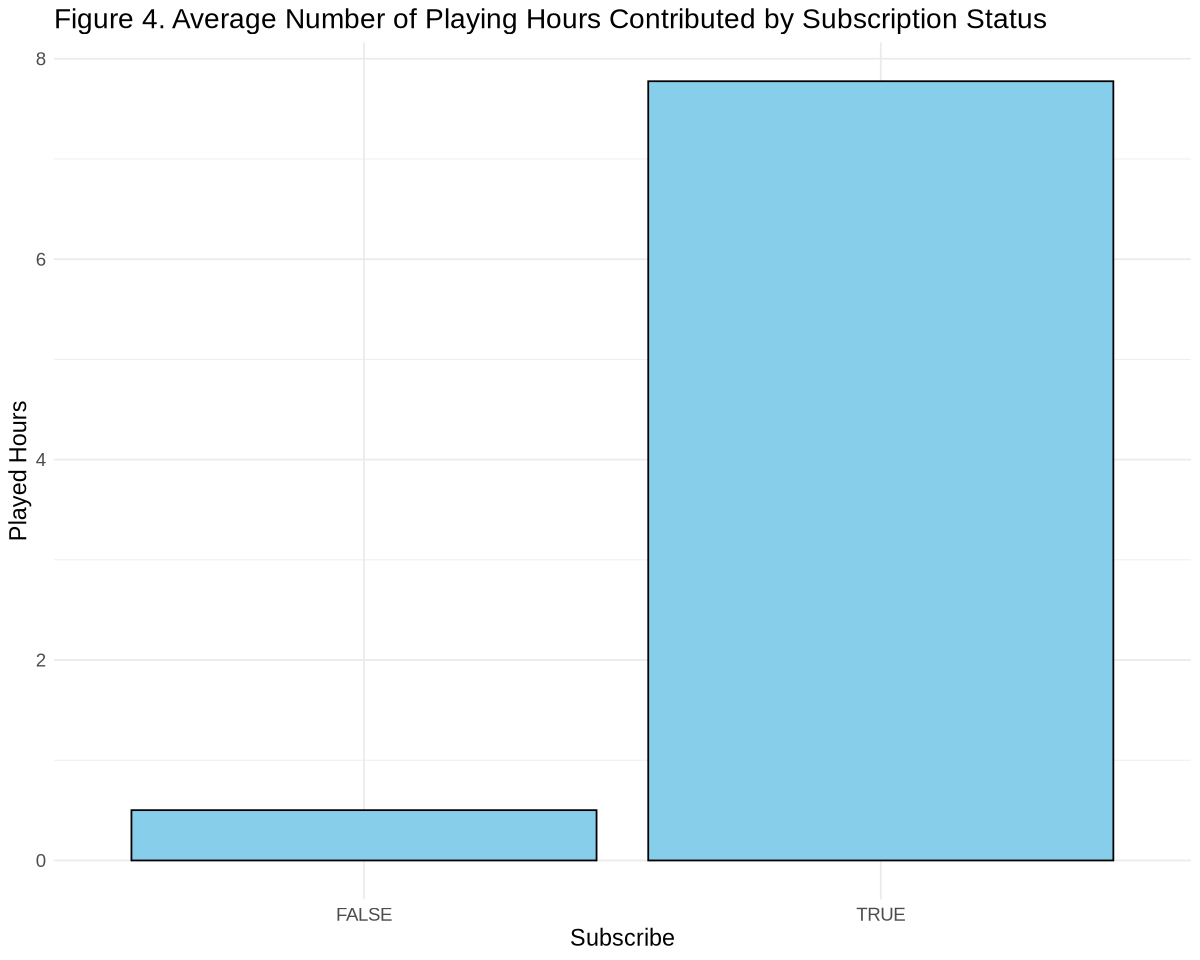

In [57]:
options(repr.plot.width = 10, repr.plot.height = 8)
subscribe_summary <- players_tidy |> 
  group_by(subscribe) |> 
  summarize(avg_hours = mean(played_hours, na.rm = TRUE))

# Create the bar graph
ggplot(subscribe_summary, aes(x = subscribe, y = avg_hours)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") + 
  labs(
    title = "Figure 4. Average Number of Playing Hours Contributed by Subscription Status",
    x = "Subscribe",
    y = "Played Hours"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 14))

**Figure 4:** The bar chart shows the average playing hours for subscribed versus non-subscribed users. Subscribed users contributed significantly more playing hours compared to non-subscribed users.

In [58]:
#convert the character variables to factor variables so they can be used as categories for KNN classification
players_tidy <- players_tidy |> 
    mutate(experience = as.factor(experience), 
           gender = as.factor(gender), 
           subscribe = as.factor(subscribe))

In [59]:
#assign numerical values to the experience, and gender variables so they can be used to calculate distances between points in KNN classification
players_tidy <- players_tidy |> 
    mutate(experience = as.numeric(experience), 
           gender = as.numeric(gender), 
           subscribe = as.numeric(subscribe))

Categorical variables such as "experience", "gender", and "subscribe" were converted into numeric factors to make them more suitable for modelling. 

The next step was finding a certain number of playing hours to be defined as a "boundary"; any playing time below this boundary will be considered a "low contributor", and any playing time above this boundary will be considered a "high contributor". 

In [60]:
#calculate the average number of played hours to determine a boundary separating high and low contributors
median_played_hours <- players_tidy |>
  summarize(median_hours = median(played_hours, na.rm = TRUE)) |>
    pull()


print(paste("The median played hours is:", median_played_hours))

[1] "The median played hours is: 0.1"


The above code output reveals that the median number of played hours in the players data set is 0.1 hours. 

Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


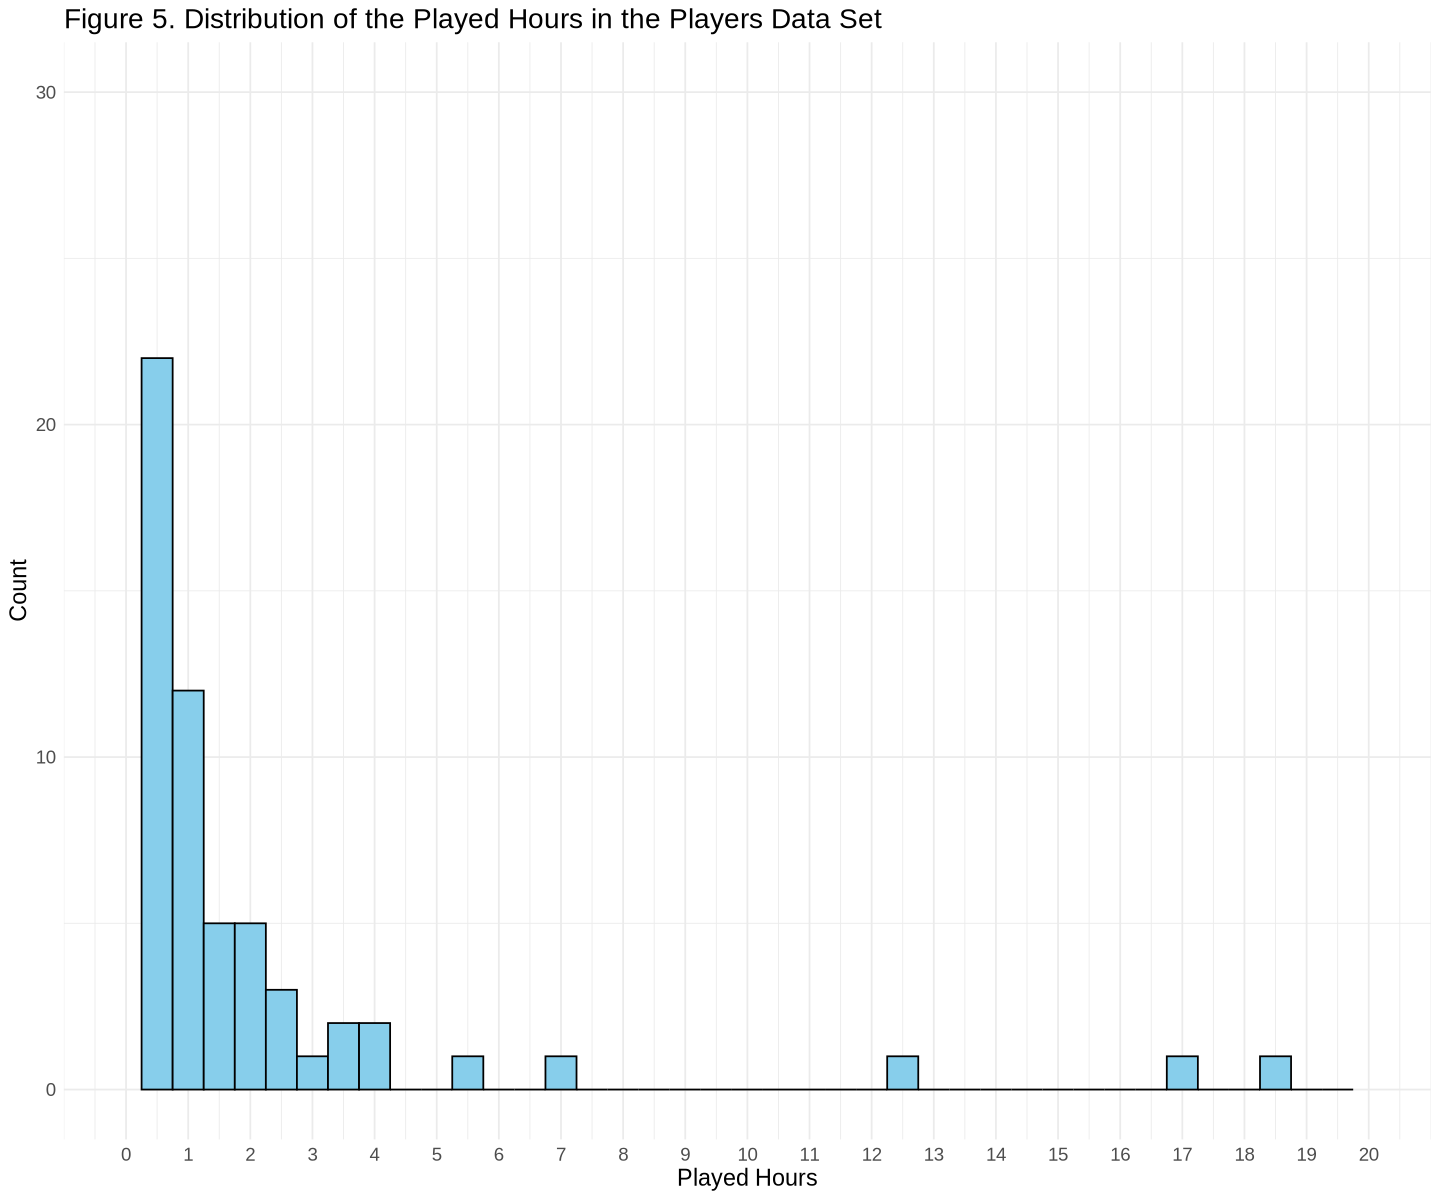

In [61]:
#create a histogram to visualize the distribution of the played_hours variable for the whole data set
options(repr.plot.width = 12, repr.plot.height = 10)
hours_dist <- ggplot(players_tidy, aes(x = played_hours)) + 
     geom_histogram(binwidth = 0.5, color = "black", fill = "skyblue") + 
     scale_x_continuous(breaks = seq(0, 20, by = 1), limits = c(0, 20)) +
     labs(x = "Played Hours", y = "Count") + 
     ggtitle("Figure 5. Distribution of the Played Hours in the Players Data Set")+ 
     scale_y_continuous(limits = c(0, 30)) +
     theme_minimal() +
     theme(text = element_text(size = 14))
hours_dist

We created a histogram showing the distribution of the played_hours variable. We set the maximum axis range to 20 to remove outliers. It is evident from the above code output that the data is skewed towards the median of 0.1 hours.

In [62]:
#calculate the number of players who contributed more than 0.1 hours
count_0.1_hours <- players_tidy |> 
    filter(played_hours > 0.1) |> 
    summarize(count = n()) 
count_0.1_hours

count
<int>
77


The above code output reveals that 77 players contributed more than 0.1 hours.

In [63]:
#calculate the number of players who contributed 0.5 hours or more
count_0.5_hours <- players_tidy |> 
    filter(played_hours >= 0.5) |> 
    summarize(count = n()) 
count_0.5_hours

count
<int>
57


The above code output reveals that 57 players contributed 0.5 hours or more. 

In [64]:
#calculate the number of players who contributed 0.5 hours or more
count_1_hour <- players_tidy |> 
    filter(played_hours >= 1) |> 
    summarize(count = n()) 
count_1_hour

count
<int>
42


The above code output reveals that 42 players contributed 1 hour or more.

In [81]:
#set the boundary separating High and Low Contributors 
boundary <- 1  

The median value of 0.1 hours (6 minutes) is not a high enough value to be classified as a low contributor, considering that there are outliers in the data set. For example, the histogram shows that the maximum value for the played_hours variable is 223 hours. Nonetheless, there are still a significant amount of players who contributed at least 1 hour.

Therefore, we classified players who contributed at least 1 hour as "high contributors" and players who contributed less than 1 hour as "low contributors."

In [66]:
#assign a contributor label to each played hours value
players_tidy <- players_tidy |> 
    mutate(contributor = factor(ifelse(played_hours > boundary, "High Contributor", "Low Contributor")))

A new binary variable "contributor" was mutated based on the boundary of 1 played hour in the dataset. 

In [67]:
#set the seed for the project
set.seed(2024) 

#Split the data into a train:test ratio of 3:1
players_split <- initial_split(players_tidy, prop = 0.75, strata = contributor)  
players_train <- training(players_split)   
players_test <- testing(players_split)

The modeling process began by splitting the data into 2 sets - a training set and a testing set with a ratio of 3:1. 

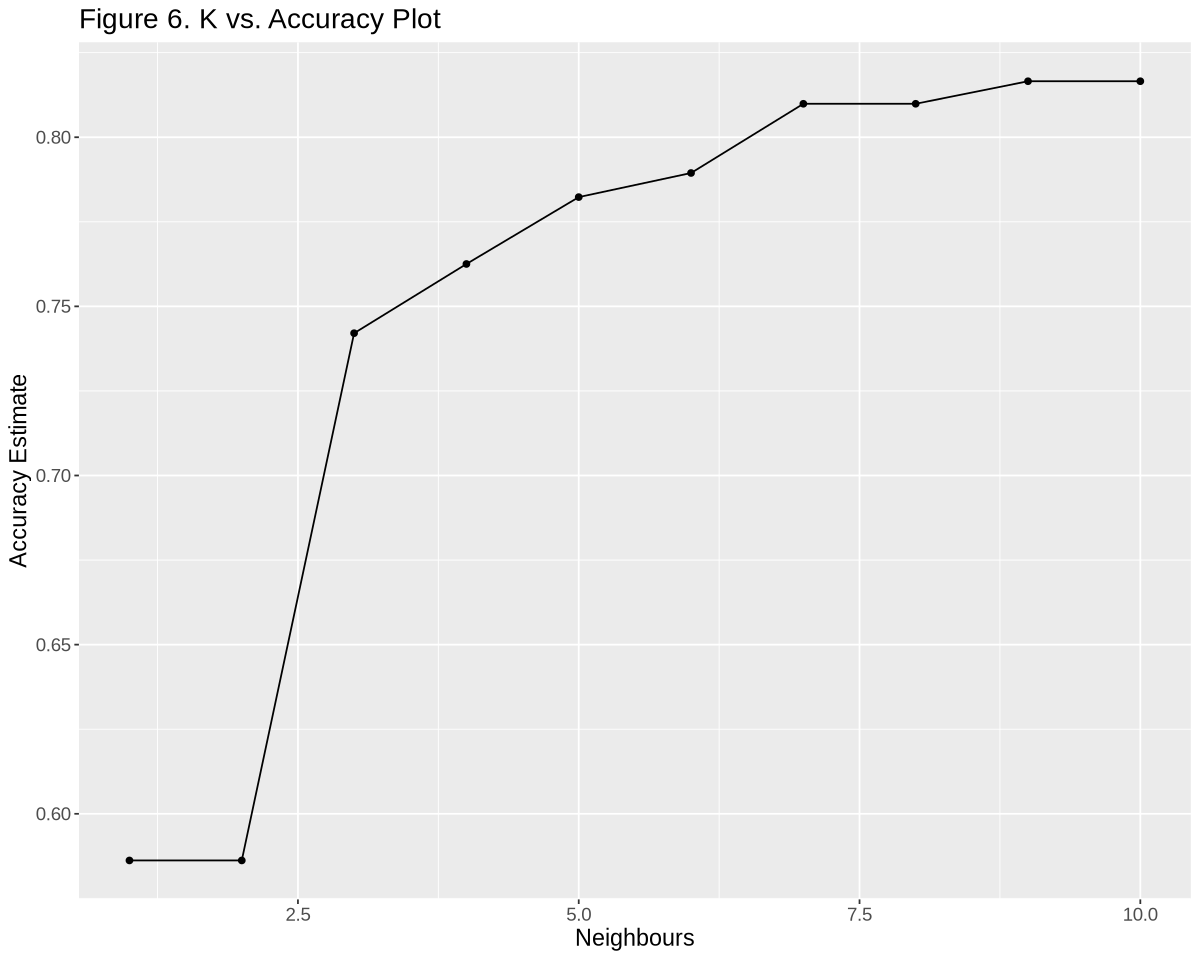

In [68]:
#select the best k value by making a k vs. accuracy plot
set.seed(2024) 
options(repr.plot.height = 8, repr.plot.width = 10)


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

training_recipe <- recipe(contributor ~ experience + gender + age + subscribe , data = players_train)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
    

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

training_vfold <- vfold_cv(players_train, v = 5, strata = contributor)

training_fit <- workflow() |>
  add_recipe(training_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = training_vfold, grid = k_vals) |>
  collect_metrics()

accuracy <- training_fit |> 
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))+ 
    geom_point()+ 
    geom_line()+ 
    labs(x = "Neighbours", y = "Accuracy Estimate") + 
    ggtitle("Figure 6. K vs. Accuracy Plot") +
    theme(text = element_text(size = 14))
    
cross_val_plot


**Figure 6:** The plot illustrates the relationship between the number of neighbors (K) and the accuracy estimate for a K-Nearest Neighbors (KNN) classification model. The accuracy increases sharply from K=2 to K=3 and then gradually improves, reaching a plateau around K=8 to K=10.

A KNN classification model was used to predict whether players were high or low contributors. The predictors we used are: 

- age
- experience
- gender
- subscribe

To find the optimal number of neighbours, k, we performed a 5-fold cross-validation, tuning the model over a range of k values (1 - 20). The k value with the highest accuracy (9) was chosen.

In [69]:
# Set the seed. Don't remove this!
set.seed(9999) 

# your code here
best_k <- accuracy |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(training_recipe) |>
  add_model(players_spec) |>
  fit(data = players_train)

players_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

players_metrics <-  players_predictions|>
   metrics(truth = contributor, estimate = .pred_class)

players_conf_mat <- players_predictions|>
    conf_mat(truth = contributor, estimate = .pred_class)
players_conf_mat
players_metrics

                  Truth
Prediction         High Contributor Low Contributor
  High Contributor                0               0
  Low Contributor                 9              40

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8163265
kap,binary,0.0000000


The KNN model was trained with the optimal k value (9) and was evaluated using the testing dataset. Our model's performance metrics resulted in 81.6% accuracy.

Additional visualizations were added to explore the predicted distribution of high and low contributors across the key variables. We used separate histograms and bar plots to illustrate how age, gender, experience and subscription status influenced player contributions, predicted by our model. 

In [70]:
#add a predicted contributor column to the players_test set
players_predictions <- players_predictions |> 
    mutate(
        predicted_contributor = .pred_class, 
        predicted_contributor = factor(predicted_contributor, levels = c("Low Contributor", "High Contributor")),
        #Convert numeric values back to categorical values
        gender = factor(gender, levels = 1:7, labels = c("Agender", "Female", "Male", "Non-binary", "Other", "Prefer not to say", "Two-Spirited")),
        experience = factor(experience, levels = 1:5, labels = c("Amateur", "Beginner", "Pro", "Regular", "Veteran")),
        subscribe = factor(subscribe, levels = 1:2, labels = c("FALSE", "TRUE")))


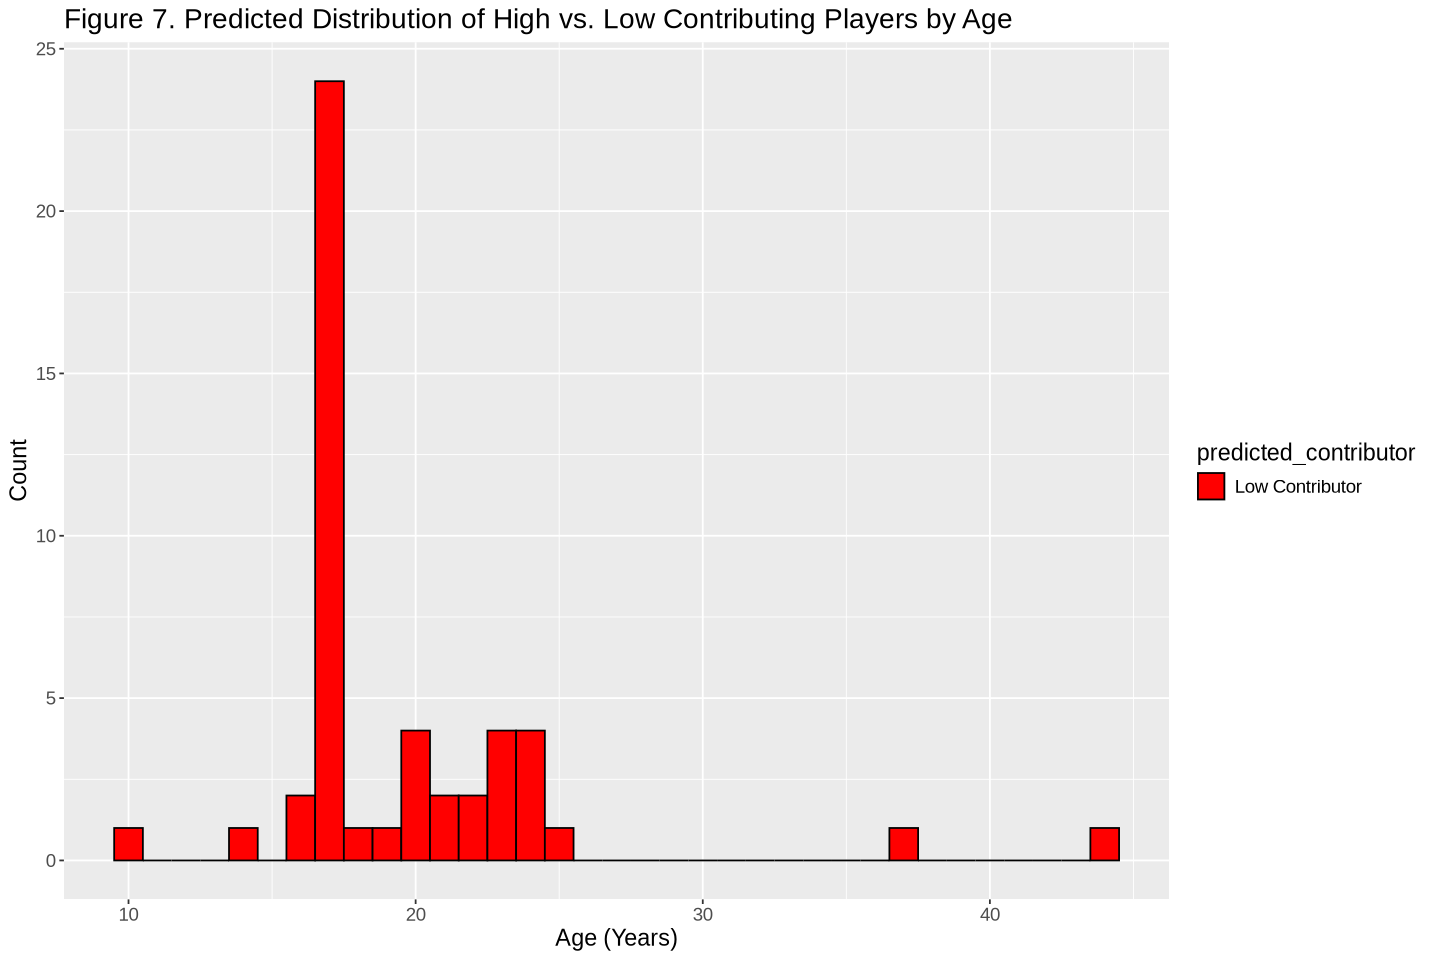

In [78]:
#create a histogram showing the distributions of high and low contributors by age
options(repr.plot.width = 12, repr.plot.height = 8)
age_contributor_plot <- ggplot(players_predictions, aes(x = age, fill = predicted_contributor)) +
  geom_histogram(binwidth = 1, color = "black") +  
  scale_fill_manual(values = c("Low Contributor" = "red", "High Contributor" = "green3")) +  
  labs(x = "Age (Years)", y = "Count") +
  ggtitle("Figure 7. Predicted Distribution of High vs. Low Contributing Players by Age") +
  theme(text = element_text(size = 14))
age_contributor_plot


**Figure 7:** The histogram illustrates the predicted distribution of high versus low contributing players by age. The x-axis represents the age of players, while the y-axis shows the count of players. The bars colored in red indicate low contributors, with the highest concentration around the age of 20. There are smaller counts of low contributors across other ages, including early teens and late 30s to early 40s. There is no predicted high contributor. 

Warning message in geom_bar(binwidth = 1, color = "black"):
“Ignoring unknown parameters: `binwidth`”


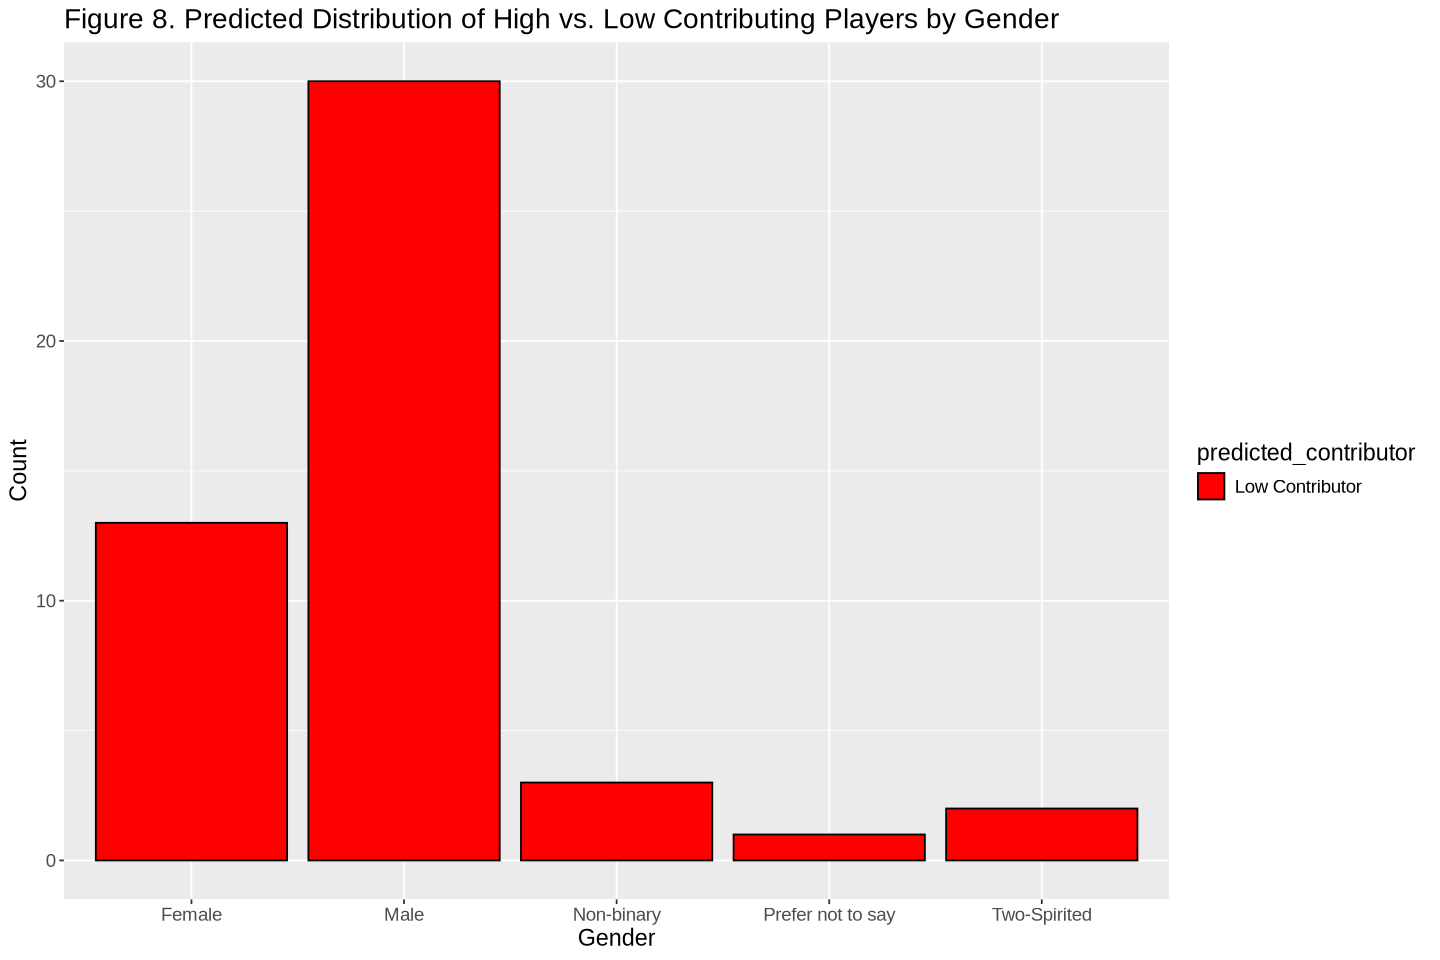

In [79]:
#create a histogram showing the distributions of high and low contributors by gender
gender_contributor_plot <- ggplot(players_predictions, aes(x = gender, fill = predicted_contributor)) +
  geom_bar(binwidth = 1, color = "black") +  
  scale_fill_manual(values = c("Low Contributor" = "red", "High Contributor" = "green3")) +  
  labs(x = "Gender", y = "Count") +
  ggtitle("Figure 8. Predicted Distribution of High vs. Low Contributing Players by Gender") +
  theme(text = element_text(size = 14))
gender_contributor_plot

**Figure 8:** The bar chart displays the predicted distribution of low contributing players by gender. The x-axis represents different gender categories, while the y-axis shows the count of players. All bars are red, indicating that there are only low contributors across all gender categories. The chart highlights that males have the highest count of low contributors, followed by females, with lower counts for Non-binary, Prefer not to say, and Two-Spirited categories.

Warning message in geom_bar(binwidth = 1, color = "black"):
“Ignoring unknown parameters: `binwidth`”


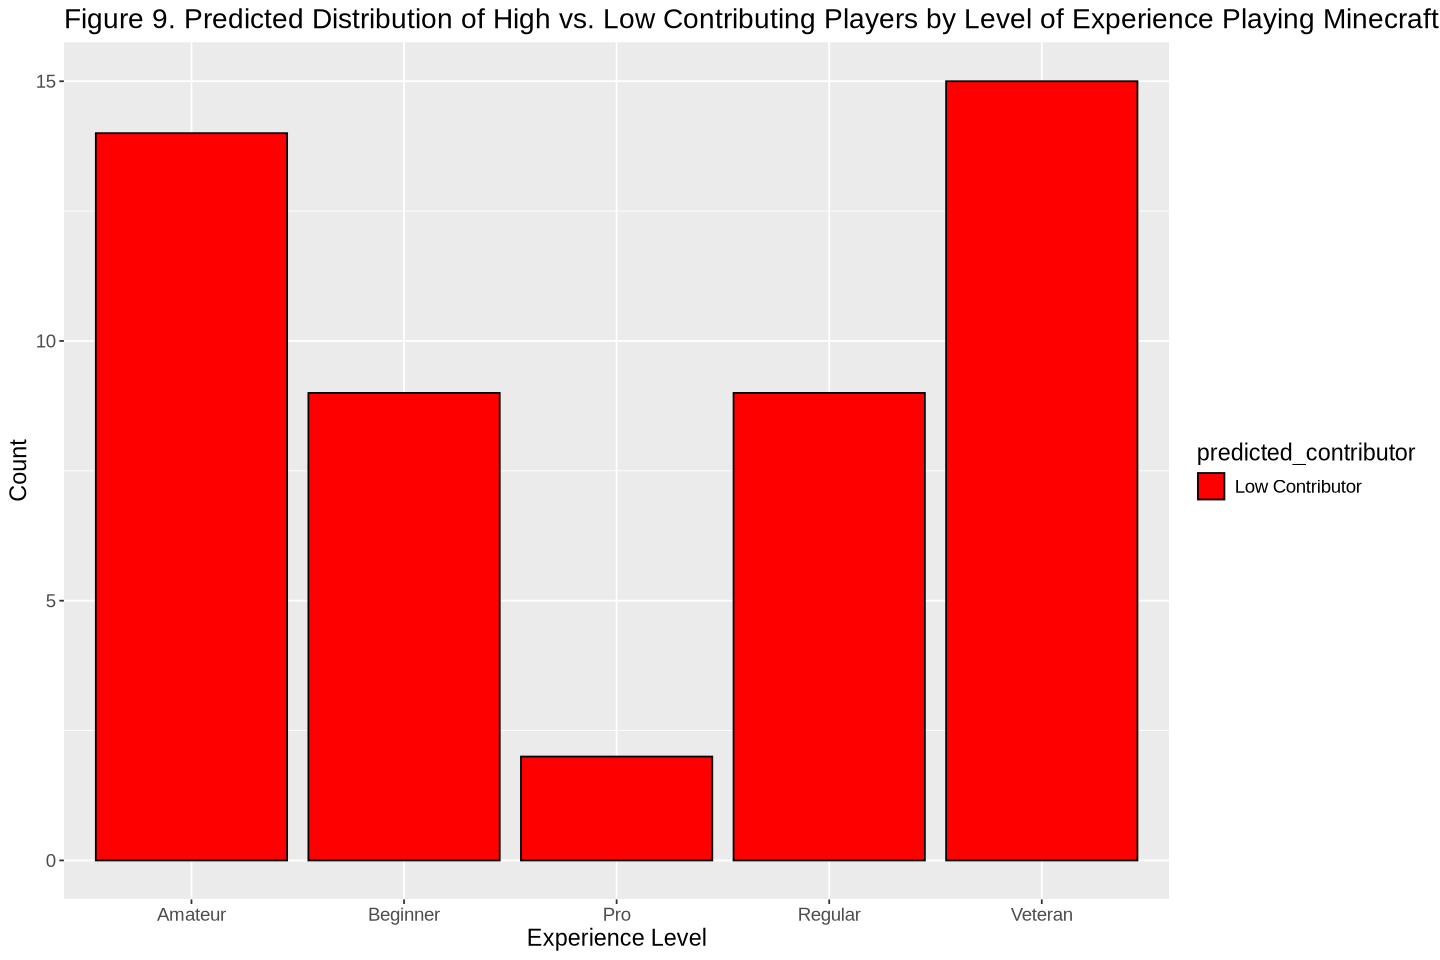

In [80]:
#create a histogram showing the distributions of high and low contributors by experience level
experience_contributor_plot <- ggplot(players_predictions, aes(x = experience, fill = predicted_contributor)) +
  geom_bar(binwidth = 1, color = "black") +  
  scale_fill_manual(values = c("Low Contributor" = "red", "High Contributor" = "green3")) +  
  labs(x = "Experience Level", y = "Count") +
  ggtitle("Figure 9. Predicted Distribution of High vs. Low Contributing Players by Level of Experience Playing Minecraft") +
  theme(text = element_text(size = 14))
experience_contributor_plot

**Figure 9:** The bar chart illustrates the predicted distribution of high and low contributing players by level of experience playing Minecraft. The x-axis represents different experience levels: Amateur, Beginner, Pro, Regular, and Veteran. The y-axis shows the count of players. All bars are red, indicating that all players are low contributors, with Amateurs and Veterans having the highest counts.

Warning message in geom_bar(binwidth = 1, color = "black"):
“Ignoring unknown parameters: `binwidth`”


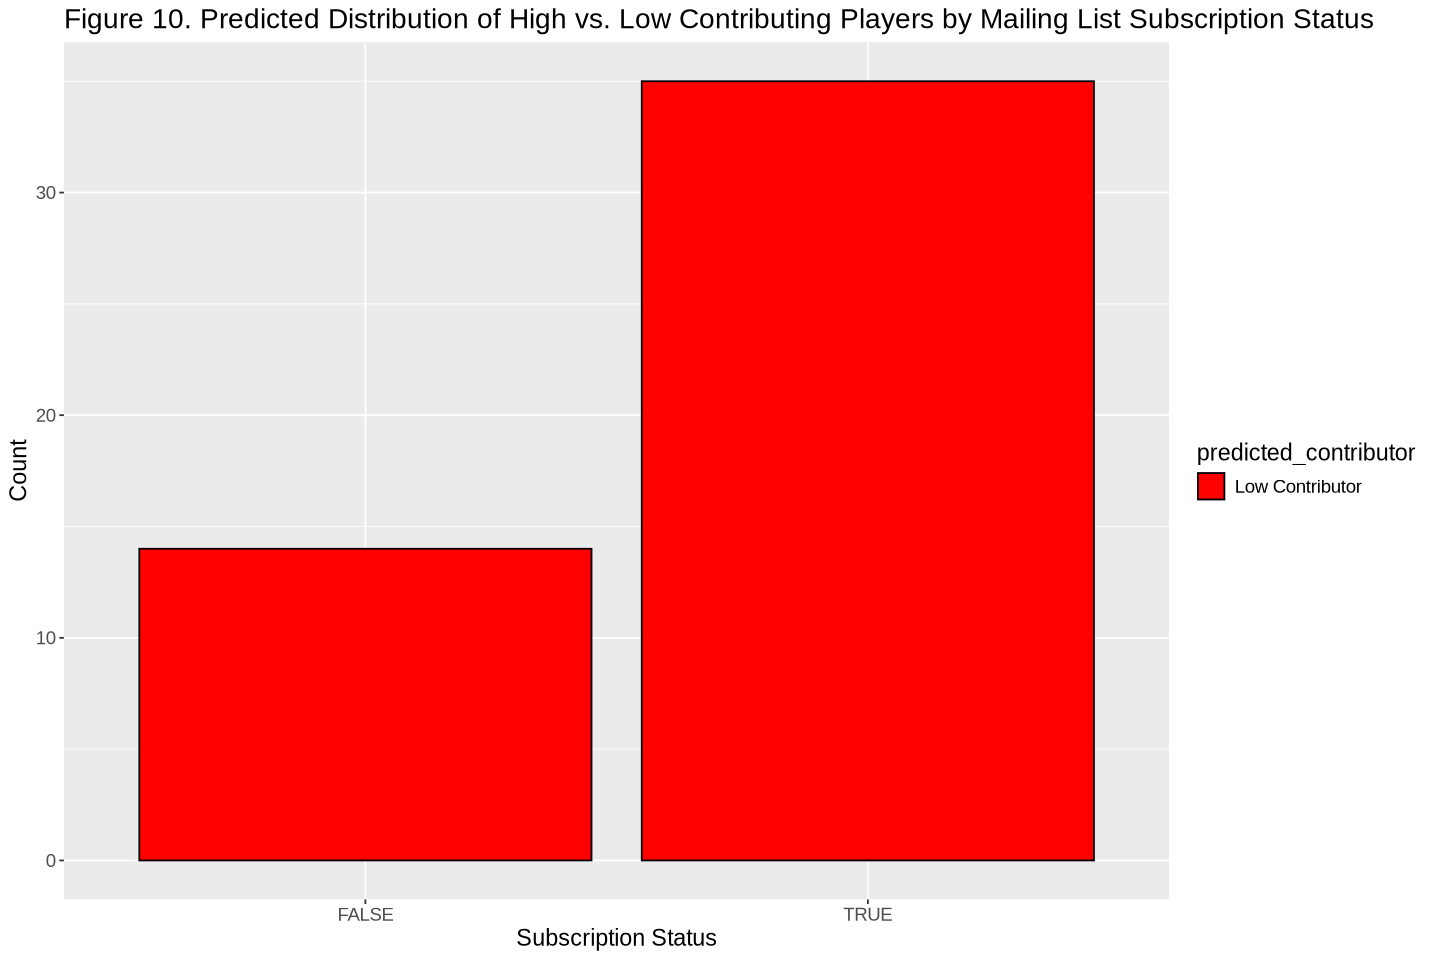

In [74]:
#create a histogram showing the distributions of high and low contributors by subscription status
subscribe_contributor_plot <- ggplot(players_predictions, aes(x = subscribe, fill = predicted_contributor)) +
  geom_bar(binwidth = 1, color = "black") +  
  scale_fill_manual(values = c("Low Contributor" = "red", "High Contributor" = "green3")) +  
  labs(x = "Subscription Status", y = "Count") +
  ggtitle("Figure 10. Predicted Distribution of High vs. Low Contributing Players by Mailing List Subscription Status") +
  theme(text = element_text(size = 14))
subscribe_contributor_plot

**Figure 10:** The bar chart shows the predicted distribution of low contributing players by mailing list subscription status. The x-axis represents the subscription status (TRUE for subscribed, FALSE for not subscribed), and the y-axis shows the count of players. All bars are red, indicating low contributors, with subscribed players (TRUE) having a significantly higher count than non-subscribed players (FALSE).

## Discussion

#### Our Expected Results


Based on Figure 1 - 4, which was our exploratory visualizations of the predictor variables (age, experience, gender, and subscription status) vs. played_hours, we predicted that players who are
- Under the age of 25
- Non-binary in gender
- Subscribed to the PLAICraft email list
- “Regular” Minecraft experience level

would be high contributors. These player categories contributed the highest average number of played hours in the “players.csv” dataset. 

#### Findings Summary


Our KNN classification model was unable to correctly predict any high contributors despite having an accuracy of 81.6%. Figures 4 to 7 reveal that our model only predicted the majority class (low contributor) on the test set, indicating that our model could not effectively differentiate between high and low contributors.

According to the confusion matrix, 0 data points were true high contributors and 0 high contributors were predicted to be low contributors. 40 data points were correctly predicted as low contributors and 9 data points were predicted to be low contributors but were supposed to be high contributors. 

One of the main issues was that the played hours data is heavily skewed toward the median of 0.1 hours (6 minutes), which we determined was too low to be considered a high contributor. The data set also contained outliers, such as the maximum play time of 223 hours. In addition, the boundary separating the high and low contributors was set to 1 hour; however, only 42 out of 196 players contributed 1 hour or more. This imbalance increased the likelihood of the model's nearest neighbours being low contributors.

Furthermore, the limited number of observations in the "players.csv" data set caused challenges when splitting the data set into training and testing sets. By only containing 196 observations, splitting 75% of these observations into the training set resulted in 147 observations in the training set and only 49 observations in the testing set. The small testing set may not have been an accurate representation of the entire data set, especially if many of the data points in the testing set were low contributors.

Due to the reasons above, it is difficult to conclude which kinds of players are more likely to be high contributors. 


#### Impact of Our Findings

Again, it is difficult to summarize the relationship between player type and play time based on the model we constructed. Although we couldn’t conclude any findings regarding player type, we do have few findings regarding model-construction.
Our findings suggest that additional data collection is needed to obtain a larger and less-skewed data set. It would also be beneficial to collect observations from players who will contribute more than 1 hour of playtime so the data set contains more players classified as high contributors. This will make the data set have more variety and thus help in better model construction.

In the current data set only 42 players are classified as high contributors. Our model struggles to effectively predict this group since not too many “examples” of high contributors exist to help the model better understand this group. For now, everyone has the potential to be a high contributor. Recruiting a wide range of players is the best option at this point, rather than targeting a certain group of people.

#### Further Questions These Findings Could Lead to

If the data is skewed at 0.1 hours (6 minutes) and with more data collection we get the same result. This would suggest that the majority of players are only able to contribute 6 minutes of play time or less. In that case, any play time amount greater than or equal to 0.1 hours would be considered a high contributor. 

According to Woodward (“Minecraft User Statistics: How Many People Play Minecraft in 2024?”), the number of Minecraft players increased by over 14 million from 2020 to 2021. It was also estimated that about 30% of Minecraft players use the mobile version of the game regularly. In addition, the mobile version of Minecraft generated 158 million dollars in revenue, but this revenue decreased to 102.2 million dollars in 2022 (Woodward, 2024). 

Minecraft’s popularity is decreasing due to the lack of interest in the game’s recent updates (Carefoot, 2020). It was also mentioned that players who played Minecraft in the years of its peak popularity (2012 to 2013) have gotten older and are no longer inclined to play their childhood games such as Minecraft (Carefoot, 2020). Additionally, people do not have as much time to play the game anymore as they did during the pandemic (DiFrancisco-Donoghue, Joanne, et al., 2023). Therefore, the above reasons could indicate why most players in the “players.csv” data set are contributing less than 1 hour.

Some of the questions these findings could lead to include: 

Would targeting younger generations or incorporating features from older versions of Minecraft into the PLAICraft game increase the likelihood that players contribute more hours to the game?

Could recording additional observations in the “players.csv” dataset such as players' location, whether they play alone or with friends, or the size of the game server improve the ability to predict high-contributing players using KNN classification models?

Would spending more resources to include more high-contributing players to the data set  increase the ability to predict high contributors using KNN classification models?

#### Works Cited

Carefoot, J “Is “Minecraft” Dying? Hubpages, 20 December, 2020, 
https://discover.hubpages.com/games-hobbies/Minecraft-is-Dying

DiFrancisco-Donoghue, Joanne, et al. 
  “Gaming in Pandemic Times: An International Survey Assessing the Effects of COVID-19 Lockdowns on Young Video Gamers’ Health.” International Journal of Environmental Research and Public Health, vol. 20, no. 19, Sept. 2023, p. 6855. https://doi.org/10.3390/ijerph20196855.
  
Woodward, M “Minecraft User Statistics: How Many People Play Minecraft in 2024?” SearchLogistics, 23 June 2024, www.searchlogistics.com/learn/statistics/minecraft-user-statistics.
 


